In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [4]:
df = pd.read_csv('./results/master_file.csv')

In [5]:
df.shape

(511877, 12)

In [6]:
df.drop('Request ID', axis=1, inplace=True)
df.drop('Test case name', axis=1, inplace=True)
df.drop('Test suite name', axis=1, inplace=True)

In [7]:
df = df[df['Request Result'] != 'FAIL'].copy()

In [8]:
df.describe(include='all')

,Endpoint,Method,Status Code,Start time,Duration till headers received[ms],Duration till body received[ms],Request Body Length,Response Body Length,Request Result
count,503326,503326,503326.000000,503326,503326.000000,503326.000000,503326.000000,503326.000000,503326
unique,42,4,NaN,380708,NaN,NaN,NaN,NaN,1
top,/g/user,POST,NaN,2023-05-09 09:13:21.723,NaN,NaN,NaN,NaN,PASS
freq,156620,242203,NaN,75,NaN,NaN,NaN,NaN,503326
mean,NaN,NaN,229.606440,NaN,606.199239,638.379609,113.068860,604.205535,NaN
std,NaN,NaN,71.660106,NaN,1671.499401,2255.393140,216.728453,1038.466959,NaN
min,NaN,NaN,200.000000,NaN,0.000000,2.000000,0.000000,0.000000,NaN
25%,NaN,NaN,200.000000,NaN,63.000000,66.000000,0.000000,24.000000,NaN
50%,NaN,NaN,200.000000,NaN,112.000000,115.000000,36.000000,177.000000,NaN
75%,NaN,NaN,200.000000,NaN,363.000000,369.000000,83.000000,1014.000000,NaN


In [9]:
from pytz import timezone

# Convert 'Start time' column to datetime data type
df['Start time'] = pd.to_datetime(df['Start time'])

# Convert the timezone of the datetime object from UTC to CST
df['Start Time CST'] = df['Start time'].dt.tz_localize('UTC')
df['Start Time CST'] = df['Start Time CST'].dt.tz_convert('US/Central')

# The average response time by endpoint

In [10]:
grouped = df.groupby('Endpoint')['Duration till body received[ms]'].mean()

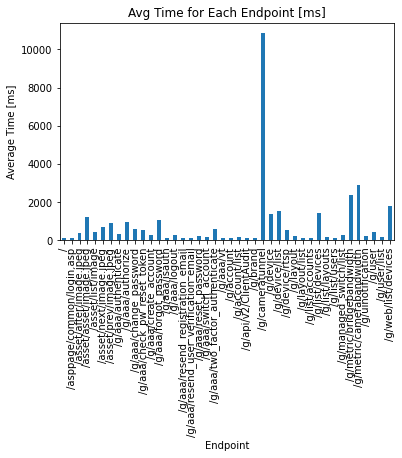

In [11]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Average Time [ms]')
plt.title('Avg Time for Each Endpoint [ms]')
plt.show()

## Breakdown: average response time by endpoint compared to avg time today

In [12]:
import pandas as pd
from datetime import datetime, timedelta
import pytz


avg_duration = df.groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration = avg_duration.rename(columns={'Duration till body received[ms]': 'avg_duration'})

# get the average duration for the last 24 hours
#last_24_hours = datetime.now() - timedelta(hours=24)
last_24_hours = datetime.now(tz=pytz.timezone('US/Central')) - timedelta(hours=24)
avg_duration_last_24_hours = df[df['Start Time CST'] >= last_24_hours].groupby('Endpoint')['Duration till body received[ms]'].mean().reset_index()
avg_duration_last_24_hours = avg_duration_last_24_hours.rename(columns={'Duration till body received[ms]': 'avg_duration 24_hrs'})

# merge the two dataframes on the 'endpoints' column
result = pd.merge(avg_duration, avg_duration_last_24_hours, on='Endpoint', how='left')

# calculate percentage change
result['percentage_change'] = ((result['avg_duration 24_hrs'] - result['avg_duration']) / result['avg_duration']) * 100

result = result.round(0) # round to whole numbers
# print the result
print(result.to_string(index=False))

                             Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
                                    /         107.0                  NaN                NaN
            /asppage/common/login.asp         121.0                  NaN                NaN
              /asset/after/image.jpeg         383.0                 62.0              -84.0
              /asset/asset/image.jpeg        1229.0                586.0              -52.0
                    /asset/list/image         423.0                 45.0              -89.0
               /asset/next/image.jpeg         702.0                573.0              -18.0
               /asset/prev/image.jpeg         897.0               1310.0               46.0
                  /g/aaa/authenticate         300.0                220.0              -27.0
                     /g/aaa/authorize         947.0                750.0              -21.0
               /g/aaa/change_password         560.0                552.0        

In [13]:
# filter rows with percentage_change greater than 20%
result_filtered = result[result['percentage_change'] > 20].sort_values('percentage_change', ascending=False)

# print the filtered result without index
print(result_filtered.to_string(index=False))

              Endpoint  avg_duration  avg_duration 24_hrs  percentage_change
/g/managed_switch/list         262.0                581.0              121.0
         /g/aaa/isauth         102.0                163.0               60.0
        /g/device/list        1538.0               2323.0               51.0
/asset/prev/image.jpeg         897.0               1310.0               46.0
       /g/list/devices        1402.0               1961.0               40.0
   /g/web/list/devices        1771.0               2320.0               31.0


### Worst performaning endpoint all time

In [14]:
df_sorted = df.sort_values(by='Duration till body received[ms]', ascending=False)
df_sorted.iloc[0]

Endpoint                                     /g/metric/camerabandwidth
Method                                                             GET
Status Code                                                      200.0
Start time                                  2023-04-29 17:45:24.544000
Duration till headers received[ms]                              203887
Duration till body received[ms]                                 203892
Request Body Length                                                  0
Response Body Length                                              8616
Request Result                                                    PASS
Start Time CST                        2023-04-29 12:45:24.544000-05:00
Name: 258550, dtype: object

### Worst performaning endpoint last 24 hours

In [15]:
df_last_24_hrs = df[df['Start Time CST'] >= last_24_hours]
#print (df[df_huh['Duration till body received[ms]'].idxmax()])
df_last_24_hrs = df_last_24_hrs.sort_values(by='Duration till body received[ms]', ascending=False)
max_duration_row = df_last_24_hrs.iloc[0]
print (max_duration_row)

Endpoint                                              /g/aaa/authorize
Method                                                            POST
Status Code                                                      200.0
Start time                                  2023-05-22 21:54:52.954000
Duration till headers received[ms]                               26346
Duration till body received[ms]                                  26346
Request Body Length                                                697
Response Body Length                                              1580
Request Result                                                    PASS
Start Time CST                        2023-05-22 16:54:52.954000-05:00
Name: 498567, dtype: object


## Median response time at each hour - all endpoints

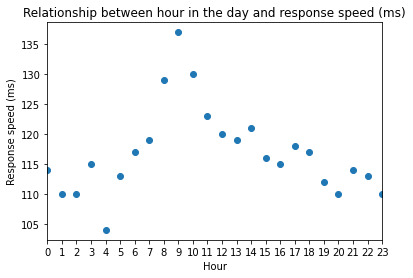

In [16]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour

#Calculate the mean duration for each hour
hourly_mean_duration = df.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()


## Median response time at each day for the last 20 days - all endpoints

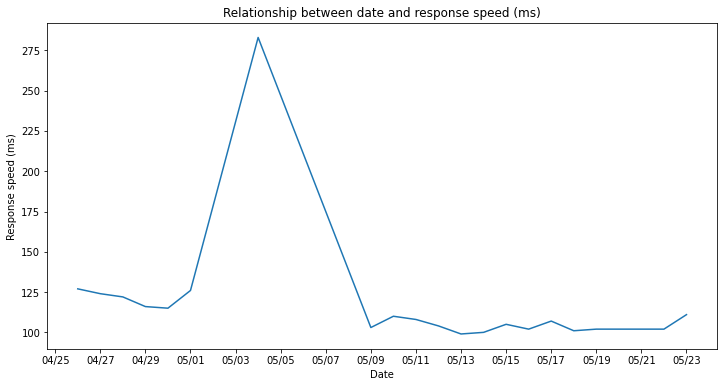

In [17]:
from matplotlib import dates as mpl_dates
import matplotlib.ticker as ticker

# Create a new column with the date value
df['Date'] = df['Start Time CST'].dt.date

# Calculate the mean duration for each day
daily_mean_duration = df.groupby('Date')['Duration till body received[ms]'].median()

# Get the last 20 days from the maximum date
last_20_days = df['Date'].unique()[-20:]

# Filter the daily mean duration data for the last 20 days
last_20_days_duration = daily_mean_duration.loc[last_20_days]

# Sort the data by date
last_20_days_duration = last_20_days_duration.sort_index()

# Build line plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(last_20_days_duration.index, last_20_days_duration)
ax.set_xlabel('Date')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between date and response speed (ms)')

# Format the x-axis tick labels to display only the month and day
date_format = mpl_dates.DateFormatter('%m/%d')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.show()

## Speed throughout the day for endpoint - g/aaa/authenticate

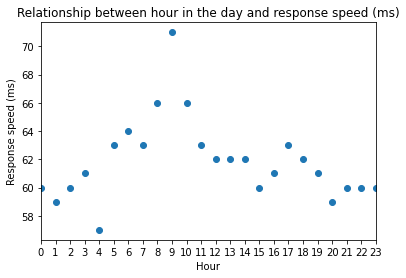

In [18]:
# Create a new column with the hour value
df['Hour'] = df['Start Time CST'].dt.hour
df_auth = df[df['Endpoint'] == '/g/aaa/authenticate']

#Calculate the mean duration for each hour
hourly_mean_duration = df_auth.groupby('Hour')['Duration till body received[ms]'].median()

# create a new dataframe with all hours included
all_hours = pd.DataFrame({'Hour': range(24)})

# Merge the hourly mean duration data with the all-hours dataframe
result = pd.merge(all_hours, hourly_mean_duration, on='Hour', how='left')

# Build scatter plot
fig, ax = plt.subplots()
ax.scatter(result['Hour'], result['Duration till body received[ms]'])
ax.set_xlabel('Hour')
ax.set_ylabel('Response speed (ms)')
ax.set_title('Relationship between hour in the day and response speed (ms)')
ax.set_xlim(0, 23) # Set the x-axis to cover 24 hours
ax.set_xticks(range(0, 24, 1))
ax.set_xticklabels(range(0, 24, 1))

plt.show()

In [19]:
import datetime
import pytz
from datetime import datetime
import calendar

today = datetime.today()
weekday_name = calendar.day_name[today.weekday()]

# filter the dataframe to include only the data for Tuesdays
df_every_someday = df[df['Start Time CST'].dt.weekday == today.weekday()]

# filter the dataframe to include only the data for today
now = datetime.now(tz=pytz.timezone('US/Central'))
df_today = df[df['Start Time CST'].dt.date == now.date()]

# calculate the mean duration for each group (Endpoint column)
mean_duration_every_someday = df_every_someday['Duration till body received[ms]'].mean()
mean_duration_today = df_today['Duration till body received[ms]'].mean()

percentage_change = ((mean_duration_today - mean_duration_every_someday) / mean_duration_every_someday) * 100

print (f"Today's mean duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' mean duration: {mean_duration_every_someday:.2f} ms, Percentage change: {percentage_change:.2f}%")

Today's mean duration: 589.71 ms, Other Tuesdays' mean duration: 637.35 ms, Percentage change: -7.47%


# The response length by endpoint

In [20]:
grouped = df.groupby('Endpoint')['Response Body Length'].mean()

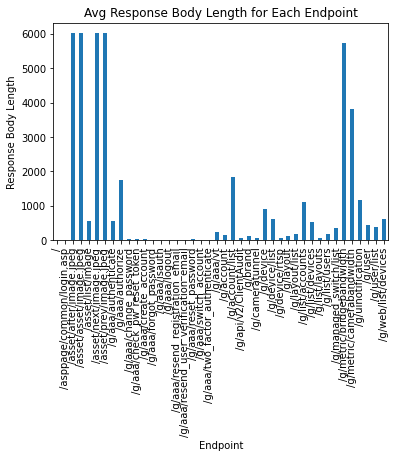

In [21]:
grouped.plot(kind='bar')
plt.xlabel('Endpoint')
plt.ylabel('Response Body Length')
plt.title('Avg Response Body Length for Each Endpoint')
plt.show()

In [23]:
import os
from zulip_integration import Zulip
zu = Zulip()
emoji = ":neutral:"
if percentage_change < -10.0:
    emoji = ":smile:"
elif percentage_change > 10.0:
    emoji = ":sad:"
zulip_msg =  f"Today's avg duration: {mean_duration_today:.2f} ms, Other {weekday_name}s' avg duration: {mean_duration_every_someday:.2f} ms \nPercentage change: {percentage_change:.2f}% "
zulip_msg += emoji
zu.send_msg(zulip_msg)
zulip_msg = "| Endpoint | Expected Duration | Today's Duration | % Change |\n"
zulip_msg += "| -------- | ----------------- | ---------------- | -------- |\n"
for index, row in result_filtered.iterrows():
    zulip_msg += f"| {row[0]} | {row[1]} ms | {row[2]} ms | {row[3]}% |\n"
zu.send_msg("WORST PERFORMING ENDPOINTS TODAY: \n")
zu.send_msg(zulip_msg)

{'result': 'success', 'msg': '', 'id': 6895073}
{'result': 'success', 'msg': '', 'id': 6895074}
{'result': 'success', 'msg': '', 'id': 6895075}
